In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[85864:92469] 
Y_train_SS = Y_train_SS[85864:92469]
Y_train_V = Y_train_V[85864:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 6605
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 6605 samples, validate on 13210 samples
Epoch 1/100
5792/6605 [=========================>....] - ETA: 0s - loss: 0.0979 - dense_5_loss: 0.0803 - dense_6_loss: 0.0176 - dense_5_mse: 0.0803 - dense_6_mse: 0.0176

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.05661, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 421us/sample - loss: 0.0913 - dense_5_loss: 0.0737 - dense_6_loss: 0.0176 - dense_5_mse: 0.0738 - dense_6_mse: 0.0175 - val_loss: 0.0566 - val_dense_5_loss: 0.0362 - val_dense_6_loss: 0.0204 - val_dense_5_mse: 0.0362 - val_dense_6_mse: 0.0204
Epoch 2/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0359 - dense_5_loss: 0.0186 - dense_6_loss: 0.0173 - dense_5_mse: 0.0186 - dense_6_mse: 0.0173
Epoch 2: val_loss improved from 0.05661 to 0.04445, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 247us/sample - loss: 0.0359 - dense_5_loss: 0.0184 - dense_6_loss: 0.0175 - dense_5_mse: 0.0184 - dense_6_mse: 0.0175 - val_loss: 0.0445 - val_dense_5_loss: 0.0242 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0242 - val_dense_6_mse: 0.0203
Epoch 3/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0273 - dense_5_loss: 0.0098 - dense_6_loss: 0.0175 - dense_5_mse: 0.0098 - dense_6_mse: 0.0175
Epoch 3: val_loss improved from 0.04445 to 0.03787, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 245us/sample - loss: 0.0273 - dense_5_loss: 0.0098 - dense_6_loss: 0.0177 - dense_5_mse: 0.0098 - dense_6_mse: 0.0175 - val_loss: 0.0379 - val_dense_5_loss: 0.0175 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0175 - val_dense_6_mse: 0.0203
Epoch 4/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0242 - dense_5_loss: 0.0069 - dense_6_loss: 0.0173 - dense_5_mse: 0.0069 - dense_6_mse: 0.0173
Epoch 4: val_loss did not improve from 0.03787
6605/6605 [==============================] - 1s 92us/sample - loss: 0.0243 - dense_5_loss: 0.0068 - dense_6_loss: 0.0174 - dense_5_mse: 0.0068 - dense_6_mse: 0.0175 - val_loss: 0.0485 - val_dense_5_loss: 0.0282 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0282 - val_dense_6_mse: 0.0203
Epoch 5/100
5792/6605 [=========================>....] - ETA: 0s - loss: 0.0231 - dense_5_loss: 0.0054 - dense_6_loss: 0.0177 - dense_5_mse: 0.0054 - dense_6_mse: 0.0177
Epoch 5: val_loss did not improv

6605/6605 [==============================] - 2s 246us/sample - loss: 0.0221 - dense_5_loss: 0.0048 - dense_6_loss: 0.0175 - dense_5_mse: 0.0048 - dense_6_mse: 0.0174 - val_loss: 0.0322 - val_dense_5_loss: 0.0120 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0120 - val_dense_6_mse: 0.0202
Epoch 7/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0214 - dense_5_loss: 0.0040 - dense_6_loss: 0.0173 - dense_5_mse: 0.0040 - dense_6_mse: 0.0173
Epoch 7: val_loss did not improve from 0.03220
6605/6605 [==============================] - 1s 94us/sample - loss: 0.0214 - dense_5_loss: 0.0041 - dense_6_loss: 0.0173 - dense_5_mse: 0.0041 - dense_6_mse: 0.0173 - val_loss: 0.0479 - val_dense_5_loss: 0.0276 - val_dense_6_loss: 0.0204 - val_dense_5_mse: 0.0276 - val_dense_6_mse: 0.0204
Epoch 8/100
6496/6605 [============================>.] - ETA: 0s - loss: 0.0215 - dense_5_loss: 0.0040 - dense_6_loss: 0.0175 - dense_5_mse: 0.0040 - dense_6_mse: 0.0175
Epoch 8: val_loss improved from 

6605/6605 [==============================] - 2s 279us/sample - loss: 0.0213 - dense_5_loss: 0.0041 - dense_6_loss: 0.0172 - dense_5_mse: 0.0041 - dense_6_mse: 0.0173 - val_loss: 0.0320 - val_dense_5_loss: 0.0118 - val_dense_6_loss: 0.0202 - val_dense_5_mse: 0.0118 - val_dense_6_mse: 0.0201
Epoch 9/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0204 - dense_5_loss: 0.0038 - dense_6_loss: 0.0167 - dense_5_mse: 0.0038 - dense_6_mse: 0.0167
Epoch 9: val_loss improved from 0.03198 to 0.03005, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 251us/sample - loss: 0.0203 - dense_5_loss: 0.0038 - dense_6_loss: 0.0165 - dense_5_mse: 0.0038 - dense_6_mse: 0.0166 - val_loss: 0.0300 - val_dense_5_loss: 0.0120 - val_dense_6_loss: 0.0181 - val_dense_5_mse: 0.0120 - val_dense_6_mse: 0.0181
Epoch 10/100
5600/6605 [========================>.....] - ETA: 0s - loss: 0.0150 - dense_5_loss: 0.0034 - dense_6_loss: 0.0116 - dense_5_mse: 0.0034 - dense_6_mse: 0.0116
Epoch 10: val_loss did not improve from 0.03005
6605/6605 [==============================] - 1s 90us/sample - loss: 0.0155 - dense_5_loss: 0.0036 - dense_6_loss: 0.0120 - dense_5_mse: 0.0036 - dense_6_mse: 0.0120 - val_loss: 0.0376 - val_dense_5_loss: 0.0278 - val_dense_6_loss: 0.0098 - val_dense_5_mse: 0.0278 - val_dense_6_mse: 0.0098
Epoch 11/100
5600/6605 [========================>.....] - ETA: 0s - loss: 0.0150 - dense_5_loss: 0.0048 - dense_6_loss: 0.0102 - dense_5_mse: 0.0048 - dense_6_mse: 0.0102
Epoch 11: val_loss improved f

6605/6605 [==============================] - 2s 250us/sample - loss: 0.0151 - dense_5_loss: 0.0047 - dense_6_loss: 0.0104 - dense_5_mse: 0.0047 - dense_6_mse: 0.0104 - val_loss: 0.0267 - val_dense_5_loss: 0.0137 - val_dense_6_loss: 0.0129 - val_dense_5_mse: 0.0137 - val_dense_6_mse: 0.0130
Epoch 12/100
5888/6605 [=========================>....] - ETA: 0s - loss: 0.0112 - dense_5_loss: 0.0051 - dense_6_loss: 0.0061 - dense_5_mse: 0.0051 - dense_6_mse: 0.0061
Epoch 12: val_loss did not improve from 0.02670
6605/6605 [==============================] - 1s 98us/sample - loss: 0.0128 - dense_5_loss: 0.0055 - dense_6_loss: 0.0074 - dense_5_mse: 0.0055 - dense_6_mse: 0.0074 - val_loss: 0.0312 - val_dense_5_loss: 0.0125 - val_dense_6_loss: 0.0186 - val_dense_5_mse: 0.0125 - val_dense_6_mse: 0.0186
Epoch 13/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0178 - dense_5_loss: 0.0040 - dense_6_loss: 0.0138 - dense_5_mse: 0.0040 - dense_6_mse: 0.0138
Epoch 13: val_loss did not im

6605/6605 [==============================] - 2s 256us/sample - loss: 0.0103 - dense_5_loss: 0.0039 - dense_6_loss: 0.0063 - dense_5_mse: 0.0039 - dense_6_mse: 0.0063 - val_loss: 0.0125 - val_dense_5_loss: 0.0079 - val_dense_6_loss: 0.0046 - val_dense_5_mse: 0.0079 - val_dense_6_mse: 0.0046
Epoch 15/100
5984/6605 [==========================>...] - ETA: 0s - loss: 0.0064 - dense_5_loss: 0.0027 - dense_6_loss: 0.0038 - dense_5_mse: 0.0027 - dense_6_mse: 0.0038
Epoch 15: val_loss improved from 0.01252 to 0.01230, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 301us/sample - loss: 0.0063 - dense_5_loss: 0.0026 - dense_6_loss: 0.0037 - dense_5_mse: 0.0026 - dense_6_mse: 0.0037 - val_loss: 0.0123 - val_dense_5_loss: 0.0071 - val_dense_6_loss: 0.0052 - val_dense_5_mse: 0.0071 - val_dense_6_mse: 0.0052
Epoch 16/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0058 - dense_5_loss: 0.0024 - dense_6_loss: 0.0034 - dense_5_mse: 0.0024 - dense_6_mse: 0.0034
Epoch 16: val_loss did not improve from 0.01230
6605/6605 [==============================] - 1s 141us/sample - loss: 0.0058 - dense_5_loss: 0.0024 - dense_6_loss: 0.0033 - dense_5_mse: 0.0024 - dense_6_mse: 0.0033 - val_loss: 0.0164 - val_dense_5_loss: 0.0108 - val_dense_6_loss: 0.0056 - val_dense_5_mse: 0.0108 - val_dense_6_mse: 0.0056
Epoch 17/100
6432/6605 [============================>.] - ETA: 0s - loss: 0.0100 - dense_5_loss: 0.0032 - dense_6_loss: 0.0068 - dense_5_mse: 0.0032 - dense_6_mse: 0.0068
Epoch 17: val_loss did not i

6605/6605 [==============================] - 2s 280us/sample - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021 - val_loss: 0.0104 - val_dense_5_loss: 0.0066 - val_dense_6_loss: 0.0039 - val_dense_5_mse: 0.0066 - val_dense_6_mse: 0.0039
Epoch 26/100
5472/6605 [=======================>......] - ETA: 0s - loss: 0.0040 - dense_5_loss: 0.0017 - dense_6_loss: 0.0023 - dense_5_mse: 0.0017 - dense_6_mse: 0.0023
Epoch 26: val_loss improved from 0.01044 to 0.00993, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 252us/sample - loss: 0.0040 - dense_5_loss: 0.0017 - dense_6_loss: 0.0023 - dense_5_mse: 0.0017 - dense_6_mse: 0.0023 - val_loss: 0.0099 - val_dense_5_loss: 0.0061 - val_dense_6_loss: 0.0039 - val_dense_5_mse: 0.0061 - val_dense_6_mse: 0.0039
Epoch 27/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0036 - dense_5_loss: 0.0014 - dense_6_loss: 0.0022 - dense_5_mse: 0.0014 - dense_6_mse: 0.0022
Epoch 27: val_loss did not improve from 0.00993
6605/6605 [==============================] - 1s 95us/sample - loss: 0.0037 - dense_5_loss: 0.0014 - dense_6_loss: 0.0022 - dense_5_mse: 0.0014 - dense_6_mse: 0.0022 - val_loss: 0.0113 - val_dense_5_loss: 0.0055 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0055 - val_dense_6_mse: 0.0058
Epoch 28/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0059 - dense_5_loss: 0.0021 - dense_6_loss: 0.0038 - dense_5_mse: 0.0021 - dense_6_mse: 0.0038
Epoch 28: val_loss improved f

6605/6605 [==============================] - 2s 259us/sample - loss: 0.0059 - dense_5_loss: 0.0021 - dense_6_loss: 0.0038 - dense_5_mse: 0.0021 - dense_6_mse: 0.0038 - val_loss: 0.0076 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0032 - val_dense_5_mse: 0.0043 - val_dense_6_mse: 0.0032
Epoch 29/100
6592/6605 [============================>.] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019
Epoch 29: val_loss did not improve from 0.00758
6605/6605 [==============================] - 1s 100us/sample - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019 - val_loss: 0.0088 - val_dense_5_loss: 0.0057 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0057 - val_dense_6_mse: 0.0031
Epoch 30/100
5760/6605 [=========================>....] - ETA: 0s - loss: 0.0034 - dense_5_loss: 0.0015 - dense_6_loss: 0.0019 - dense_5_mse: 0.0015 - dense_6_mse: 0.0019
Epoch 30: val_loss did not i

6605/6605 [==============================] - 2s 263us/sample - loss: 0.0046 - dense_5_loss: 0.0016 - dense_6_loss: 0.0030 - dense_5_mse: 0.0017 - dense_6_mse: 0.0030 - val_loss: 0.0067 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0033 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0033
Epoch 32/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018
Epoch 32: val_loss did not improve from 0.00669
6605/6605 [==============================] - 1s 102us/sample - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018 - val_loss: 0.0105 - val_dense_5_loss: 0.0063 - val_dense_6_loss: 0.0042 - val_dense_5_mse: 0.0063 - val_dense_6_mse: 0.0042
Epoch 33/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0042 - dense_5_loss: 0.0016 - dense_6_loss: 0.0026 - dense_5_mse: 0.0016 - dense_6_mse: 0.0026
Epoch 33: val_loss did not i

6605/6605 [==============================] - 2s 253us/sample - loss: 0.0025 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0058 - val_dense_5_loss: 0.0028 - val_dense_6_loss: 0.0030 - val_dense_5_mse: 0.0028 - val_dense_6_mse: 0.0030
Epoch 39/100
6432/6605 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0012 - dense_6_loss: 0.0017 - dense_5_mse: 0.0012 - dense_6_mse: 0.0017
Epoch 39: val_loss improved from 0.00576 to 0.00498, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 2s 285us/sample - loss: 0.0029 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0050 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0027
Epoch 40/100
5856/6605 [=========================>....] - ETA: 0s - loss: 0.0049 - dense_5_loss: 0.0018 - dense_6_loss: 0.0031 - dense_5_mse: 0.0018 - dense_6_mse: 0.0031
Epoch 40: val_loss did not improve from 0.00498
6605/6605 [==============================] - 1s 99us/sample - loss: 0.0046 - dense_5_loss: 0.0017 - dense_6_loss: 0.0028 - dense_5_mse: 0.0017 - dense_6_mse: 0.0028 - val_loss: 0.0055 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0031 - val_dense_6_mse: 0.0024
Epoch 41/100
6112/6605 [==========================>...] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0013 - dense_6_loss: 0.0025 - dense_5_mse: 0.0013 - dense_6_mse: 0.0025
Epoch 41: val_loss did not im

6605/6605 [==============================] - 2s 262us/sample - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0015 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0046 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0024
Epoch 43/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0012 - dense_6_loss: 0.0018 - dense_5_mse: 0.0012 - dense_6_mse: 0.0018
Epoch 43: val_loss did not improve from 0.00460
6605/6605 [==============================] - 1s 104us/sample - loss: 0.0029 - dense_5_loss: 0.0012 - dense_6_loss: 0.0017 - dense_5_mse: 0.0012 - dense_6_mse: 0.0017 - val_loss: 0.0047 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0026
Epoch 44/100
6144/6605 [==========================>...] - ETA: 0s - loss: 0.0021 - dense_5_loss: 9.9396e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.9396e-04 - dense_6_mse: 0.0011
Epoch 44: val_loss d

6605/6605 [==============================] - 2s 258us/sample - loss: 0.0022 - dense_5_loss: 9.8809e-04 - dense_6_loss: 0.0012 - dense_5_mse: 9.8962e-04 - dense_6_mse: 0.0012 - val_loss: 0.0043 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0020
Epoch 47/100
5856/6605 [=========================>....] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0011 - dense_6_loss: 0.0012 - dense_5_mse: 0.0011 - dense_6_mse: 0.0012
Epoch 47: val_loss did not improve from 0.00432
6605/6605 [==============================] - 1s 98us/sample - loss: 0.0023 - dense_5_loss: 0.0011 - dense_6_loss: 0.0013 - dense_5_mse: 0.0011 - dense_6_mse: 0.0013 - val_loss: 0.0053 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0026
Epoch 48/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0021 - dense_5_loss: 9.6634e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.6634e-04 - dense_6_mse: 0.0011
Epoch 48: val

6605/6605 [==============================] - 2s 266us/sample - loss: 0.0022 - dense_5_loss: 0.0010 - dense_6_loss: 0.0012 - dense_5_mse: 0.0010 - dense_6_mse: 0.0012 - val_loss: 0.0041 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0019
Epoch 58/100
6080/6605 [==========================>...] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.4250e-04 - dense_6_loss: 0.0012 - dense_5_mse: 9.4250e-04 - dense_6_mse: 0.0012
Epoch 58: val_loss did not improve from 0.00411
6605/6605 [==============================] - 1s 101us/sample - loss: 0.0022 - dense_5_loss: 9.4749e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.4665e-04 - dense_6_mse: 0.0013 - val_loss: 0.0047 - val_dense_5_loss: 0.0028 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0028 - val_dense_6_mse: 0.0019
Epoch 59/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0025 - dense_5_loss: 9.9257e-04 - dense_6_loss: 0.0015 - dense_5_mse: 9.9257e-04 - dense_6_mse: 0.0015
Epoc

6605/6605 [==============================] - 2s 284us/sample - loss: 0.0017 - dense_5_loss: 7.7416e-04 - dense_6_loss: 9.0165e-04 - dense_5_mse: 7.7520e-04 - dense_6_mse: 9.0410e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0018
Epoch 61/100
5920/6605 [=========================>....] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017        
Epoch 61: val_loss did not improve from 0.00357
6605/6605 [==============================] - 1s 99us/sample - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0043 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0020
Epoch 62/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.4721e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.4721e-04 - dense_6_mse: 0.00

6605/6605 [==============================] - 2s 255us/sample - loss: 0.0029 - dense_5_loss: 0.0013 - dense_6_loss: 0.0016 - dense_5_mse: 0.0013 - dense_6_mse: 0.0016 - val_loss: 0.0033 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0016
Epoch 74/100
6432/6605 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0010 - dense_6_loss: 0.0013 - dense_5_mse: 0.0010 - dense_6_mse: 0.0013
Epoch 74: val_loss did not improve from 0.00331
6605/6605 [==============================] - 1s 108us/sample - loss: 0.0024 - dense_5_loss: 0.0010 - dense_6_loss: 0.0013 - dense_5_mse: 0.0010 - dense_6_mse: 0.0013 - val_loss: 0.0070 - val_dense_5_loss: 0.0044 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0044 - val_dense_6_mse: 0.0026
Epoch 75/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0013 - dense_6_loss: 0.0012 - dense_5_mse: 0.0013 - dense_6_mse: 0.0012
Epoch 75: val_loss did not i

6605/6605 [==============================] - 2s 266us/sample - loss: 0.0019 - dense_5_loss: 7.4252e-04 - dense_6_loss: 0.0012 - dense_5_mse: 7.4316e-04 - dense_6_mse: 0.0012 - val_loss: 0.0033 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0016
Epoch 85/100
6080/6605 [==========================>...] - ETA: 0s - loss: 0.0017 - dense_5_loss: 8.1458e-04 - dense_6_loss: 9.2015e-04 - dense_5_mse: 8.1458e-04 - dense_6_mse: 9.2015e-04
Epoch 85: val_loss did not improve from 0.00328
6605/6605 [==============================] - 1s 108us/sample - loss: 0.0017 - dense_5_loss: 8.0025e-04 - dense_6_loss: 8.9755e-04 - dense_5_mse: 8.0125e-04 - dense_6_mse: 8.9909e-04 - val_loss: 0.0062 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0046 - val_dense_6_mse: 0.0017
Epoch 86/100
5600/6605 [========================>.....] - ETA: 0s - loss: 0.0015 - dense_5_loss: 7.6975e-04 - dense_6_loss: 7.7897e-04 - dense_5_mse: 7.6975e-0

6605/6605 [==============================] - 2s 270us/sample - loss: 0.0012 - dense_5_loss: 5.7123e-04 - dense_6_loss: 6.7076e-04 - dense_5_mse: 5.7225e-04 - dense_6_mse: 6.7256e-04 - val_loss: 0.0029 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0014
Epoch 96/100
6605/6605 [==============================] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.8617e-04 - dense_6_loss: 8.8032e-04 - dense_5_mse: 6.8748e-04 - dense_6_mse: 8.8272e-04
Epoch 96: val_loss did not improve from 0.00290
6605/6605 [==============================] - 1s 108us/sample - loss: 0.0016 - dense_5_loss: 6.8617e-04 - dense_6_loss: 8.8032e-04 - dense_5_mse: 6.8748e-04 - dense_6_mse: 8.8272e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0019
Epoch 97/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.5906e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.590

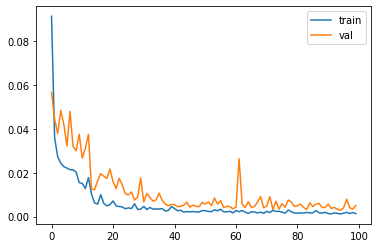

---Training time: 92.38525796 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98514, Train (V) - 0.91435
R2 scores: Validation (SS) - 0.96164, Validation (V) - 0.83343
R2 scores: Testing (SS) - 0.86276, Testing (V) - 0.61178
RMSE scores: Train (SS) - 0.02712, Train (V) - 0.03858
RMSE scores: Validation (SS) - 0.04586, Validation (V) - 0.05812
RMSE scores: Testing (SS) - 0.08499, Testing (V) - 0.08621


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

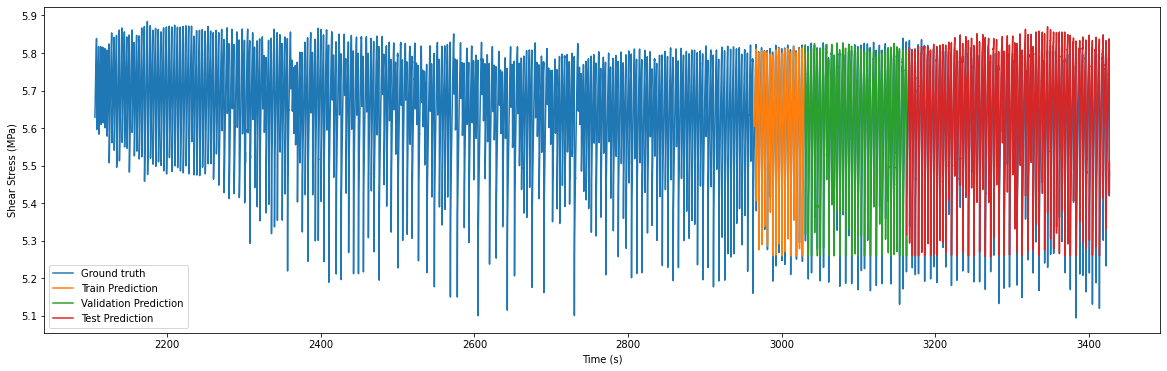

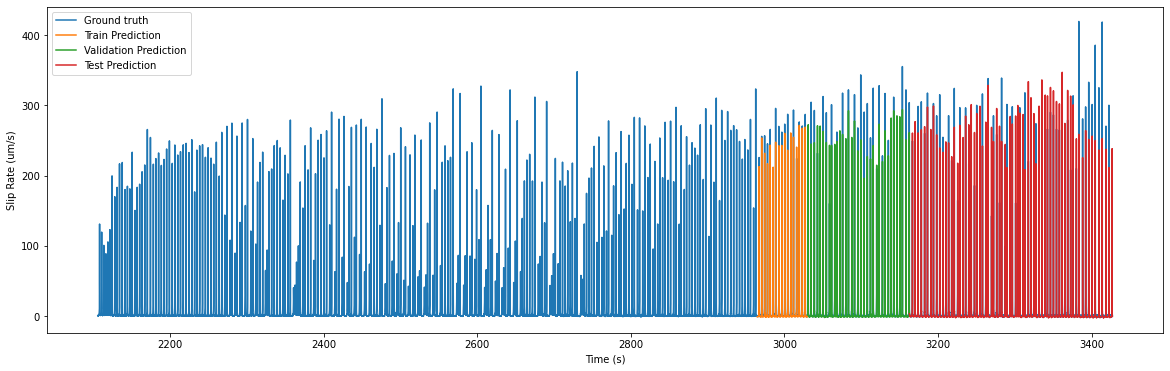

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[85864:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

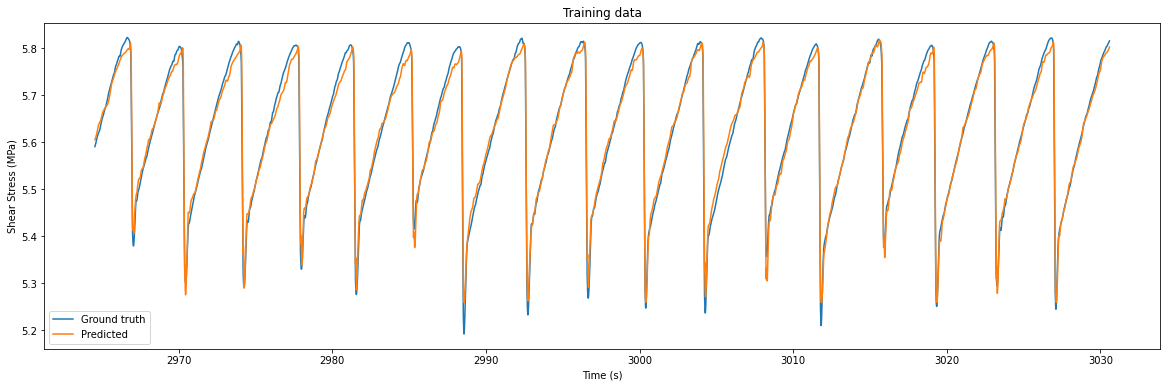

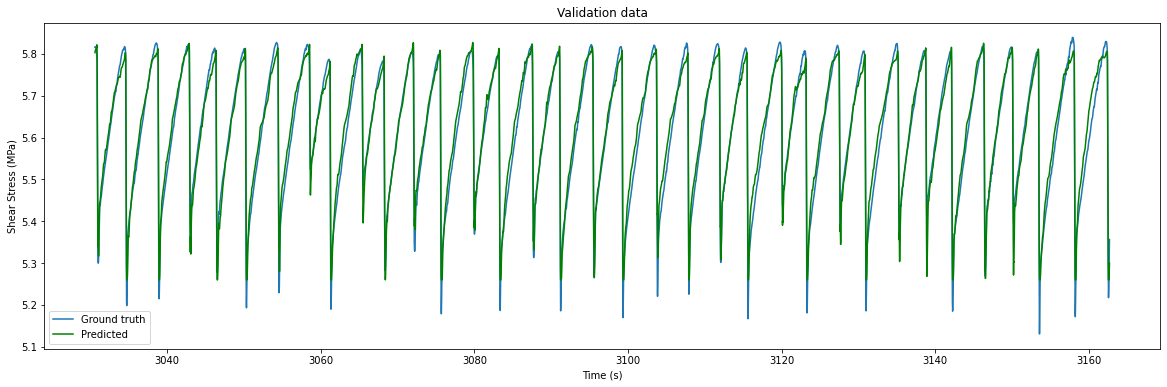

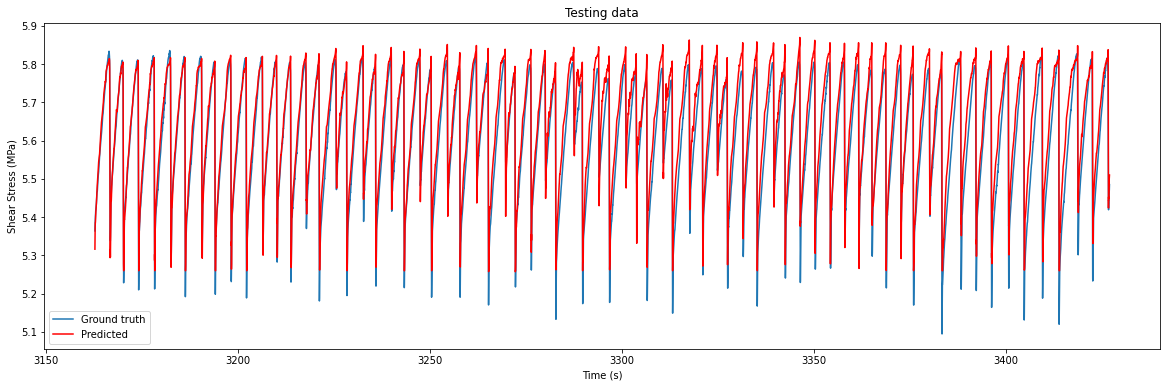

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

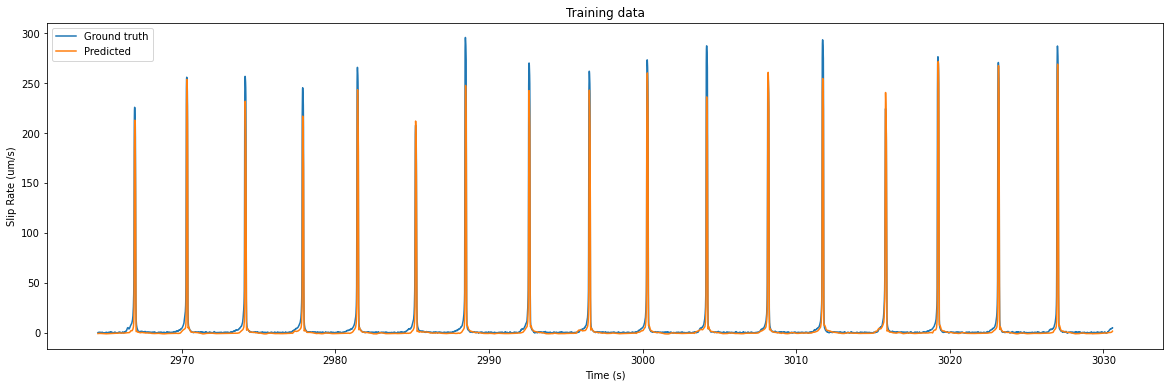

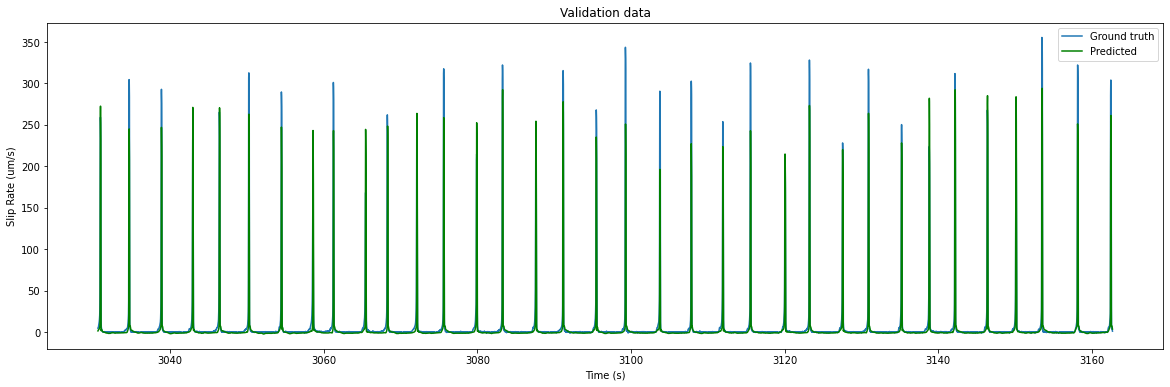

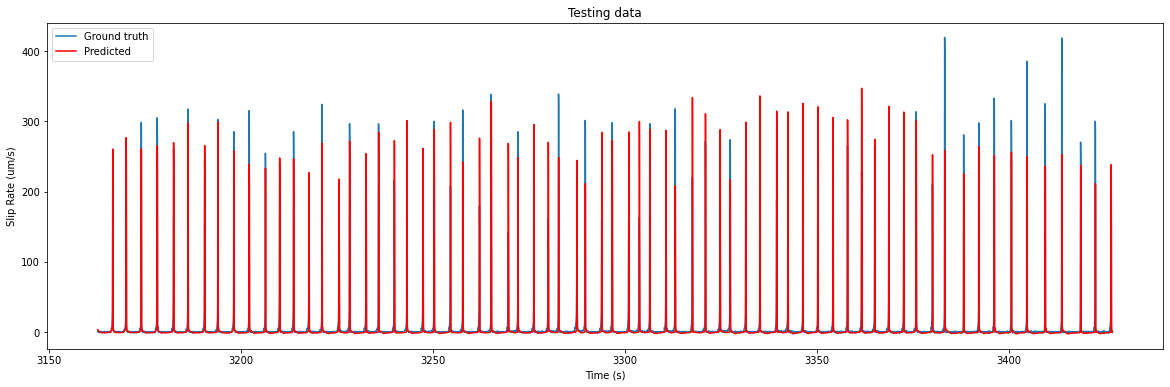

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# Extract Data

# Time 
savetxt('Whole_time.csv', ttime, delimiter=',')
savetxt('traintime.csv', traintime, delimiter=',')
savetxt('valtime.csv', valtime, delimiter=',')
savetxt('testtime.csv', testtime, delimiter=',')

# SS
savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# V
savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
savetxt('y_test_V.csv', y_test_V, delimiter=',')
savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# Download
files.download('Whole_time.csv')
files.download('traintime.csv')
files.download('valtime.csv')
files.download('testtime.csv')

files.download('Y_train_SS.csv')
files.download('Y_val_SS.csv')
files.download('y_test_SS.csv')
files.download('y_predtrain_SS.csv')
files.download('y_predval_SS.csv')
files.download('y_predtest_SS.csv')

files.download('Y_train_V.csv')
files.download('Y_val_V.csv')
files.download('y_test_V.csv')
files.download('y_predtrain_V.csv')
files.download('y_predval_V.csv')
files.download('y_predtest_V.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('Whole_time.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('Y_val_V.csv')
files.download('y_test_V.csv')
files.download('y_predtrain_V.csv')
files.download('y_predval_V.csv')
files.download('y_predtest_V.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>